In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import multiprocessing
import itertools
import sys
sys.path.append('../src/')

from simulator import Simulator

from savgol.utils import savgol_filter
from savgol.utils import asymmetric_least_squares
from savgol.utils import durbin_watson_criterion
from savgol.utils import find_peaks
from savgol.utils import rescale_deriv

In [2]:
simulator = Simulator(
    resolution=16384,
    num_peaks_range=(5, 50),
    snr_range=(15.0, 45.0),
    amplitude_range=(50, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.15, 0.15),
    noise_type='white',
)


In [3]:
def f1_score(x, true_loc, pred_loc):
    true_loc = np.sort(true_loc)
    pred_loc = np.sort(pred_loc)
    
    #mre = []
    
    fn = np.ones(len(true_loc)).astype(bool)
    fp = np.ones(len(pred_loc)).astype(bool)
    
    for i, tl in enumerate(true_loc):
        dist = np.abs(tl - pred_loc)
        indices = np.argsort(dist)
        for index in indices:
            if fp[index] and dist[index] < x['scale'][i]*1.5:
                break
        else:
            continue
            
        fn[i] = False
        fp[index] = False
        #mre.append(dist[index])
        
    fn_ = fn.copy()
    fp_ = fp.copy()
    
    tp = np.sum(fn == False)
    fp = np.sum(fp)
    fn = np.sum(fn)
    print('n_peaks:', len(true_loc), '\ntp:\t', tp.sum(), '\nfp:\t', fp.sum(), '\nfn:\t',fn.sum())
    return (tp / (tp + (1/2) * (fp + fn))), fn_, fp_
    
    
def evaluate(x, param):
    x_smooth, x_deriv = savgol_filter(x['chromatogram'], *param, deriv=2)
    x_deriv = rescale_deriv(x_deriv)
    loc = find_peaks(x_deriv, height=0.01, width=[10, 200]) / 16384
    
    score, fn, fp = f1_score(x, x['loc'], loc)
    
    
    return x_smooth, x_deriv, loc, score, fn, fp

data = simulator._generate(14)

x_smooth, x_deriv, loc, score, fn, fp = evaluate(data, (101, 3))
print('f1score:', score.round(6))

n_peaks: 48 
tp:	 42 
fp:	 0 
fn:	 6
f1score: 0.933333


(-130.0, 100.0)

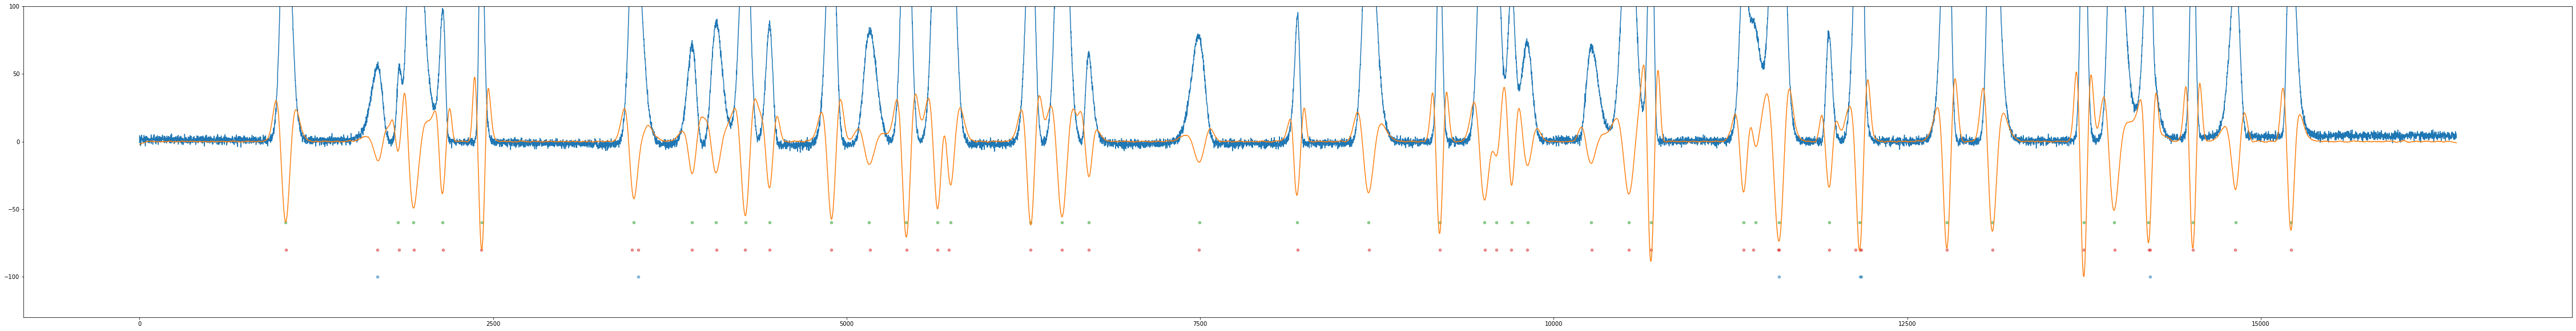

In [5]:
plt.figure(figsize=(80, 10))

x = data['chromatogram']
plt.plot(x)
plt.plot(x_deriv * 100)

plt.scatter(loc * 16384, [-60] * len(loc), c ='C2', s=20, alpha=0.5)

plt.scatter(data['loc'] * 16384, [-80] * len(data['loc']), c ='C3', s=20, alpha=0.5)

plt.scatter(np.sort(data['loc'])[fn] * 16384, [-100] * len(data['loc'][fn]), s=20, alpha=0.5)

plt.scatter(np.sort(loc)[fp] * 16384, [-120] * len(loc[fp]), s=20, alpha=0.5)

plt.ylim(-130, 100)